In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [2]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
from glob2 import glob
from numba import jit
from pandas_profiling import ProfileReport
from tqdm import tqdm

In [128]:
data_list = glob('./aT_data/data/train/*.csv')

In [129]:
# feature engineering
# 함수 정의하기.

df_train = pd.read_csv(data_list[0])
df_train.head(20)

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
0,20130101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
1,20130102,1298.70,435.0,566065.5,3.0,350301.0,35030101.0,561.0,1587.314723,116539.0,...,0,1,0,0,0,0,0,0,0,0
2,20130103,929.07,1005.0,936562.5,5.0,350402.0,35040202.0,580.0,1731.765036,812663.0,...,0,1,0,0,0,0,0,0,0,0
3,20130104,960.96,360.0,346653.0,4.0,340101.0,34010102.0,330.0,1433.421743,282245.0,...,0,1,0,0,0,0,0,0,0,0
4,20130105,720.72,5400.0,3903900.0,1.0,311201.0,31120103.0,467.0,1549.518789,347766.0,...,0,1,0,0,0,0,0,0,0,0
5,20130106,1271.27,360.0,455544.0,2.0,370401.0,37040101.0,766.0,1533.847531,469554.0,...,0,1,0,0,0,0,0,0,0,0
6,20130107,1168.83,150.0,175175.0,3.0,380201.0,38020102.0,680.0,1498.667145,294222.0,...,0,1,0,0,0,0,0,0,0,0
7,20130108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
8,20130109,1298.70,2820.0,3660336.0,10.0,210009.0,21000901.0,960.0,1671.561473,766088.0,...,0,1,0,0,0,0,0,0,0,0
9,20130110,839.16,690.0,575424.0,9.0,250003.0,25000302.0,339.0,1837.608567,747973.0,...,0,1,0,0,0,0,0,0,0,0


In [130]:
df_train = df_train.replace(' ', np.nan)
df_train['주산지_0_습도(%)'].isnull().count()

1461

In [131]:
df_train.columns

Index(['datadate', '단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
       '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
       '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
       '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
       '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
       '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)',
       '주산지_0_평균온도(℃)', '주산지_0_강수량(ml)', '주산지_0_습도(%)', '주산지_1_초기온도(℃)',
       '주산지_1_최대온도(℃)', '주산지_1_최저온도(℃)', '주산지_1_평균온도(℃)', '주산지_1_강수량(ml)',
       '주산지_1_습도(%)', '주산지_2_초기온도(℃)', '주산지_2_최대온도(℃)', '주산지_2_최저온도(℃)',
       '주산지_2_평균온도(℃)', '주산지_2_강수량(ml)', '주산지_2_습도(%)', '일자구분_중순', '일자구분_초순',
       '일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월',
       '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월'],
      dtype='object')

In [132]:
# 주산지 초기온도, 최대온도, 최저온도, 평균온도, 강수량, 습도
df_train['group_id'] = 0

df_train['주산지_초기온도'] = (df_train['주산지_0_초기온도(℃)'] + df_train['주산지_1_초기온도(℃)'] + df_train['주산지_2_초기온도(℃)'])/3
df_train['주산지_최대온도'] = (df_train['주산지_0_최대온도(℃)'] + df_train['주산지_1_최대온도(℃)'] + df_train['주산지_2_최대온도(℃)'])/3
df_train['주산지_최저온도'] = (df_train['주산지_0_최저온도(℃)'] + df_train['주산지_1_최저온도(℃)'] + df_train['주산지_2_최저온도(℃)'])/3
df_train['주산지_평균온도'] = (df_train['주산지_0_평균온도(℃)'] + df_train['주산지_1_평균온도(℃)'] + df_train['주산지_2_평균온도(℃)'])/3

df_train['주산지_강수량'] = (df_train['주산지_0_강수량(ml)'] + df_train['주산지_1_강수량(ml)'] + df_train['주산지_2_강수량(ml)'])/3
# df_train['주산지_습도'] = (df_train['주산지_0_습도(%)'] + df_train['주산지_1_습도(%)'] + df_train['주산지_2_습도(%)'])/3

df_train.drop(['도매시장코드', '도매법인코드', '산지코드 ','일자구분_중순', '일자구분_초순',
       '일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월',
       '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월',
       '주산지_0_초기온도(℃)', '주산지_1_초기온도(℃)', '주산지_2_초기온도(℃)',
       '주산지_0_최대온도(℃)', '주산지_1_최대온도(℃)', '주산지_2_최대온도(℃)',
       '주산지_0_최저온도(℃)', '주산지_1_최저온도(℃)', '주산지_2_최저온도(℃)',
       '주산지_0_평균온도(℃)', '주산지_1_평균온도(℃)', '주산지_2_평균온도(℃)',
       '주산지_0_강수량(ml)', '주산지_1_강수량(ml)', '주산지_2_강수량(ml)',
       '주산지_0_습도(%)', '주산지_1_습도(%)', '주산지_2_습도(%)'
       ], axis = 1, inplace = True)

In [133]:
df_train.columns

Index(['datadate', '단가(원)', '거래량', '거래대금(원)', '경매건수', '해당일자_전체평균가격(원)',
       '해당일자_전체거래물량(kg)', '하위가격 평균가(원)', '상위가격 평균가(원)', '하위가격 거래물량(kg)',
       '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)', '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)',
       '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)', '일자별_소매가격_최소(원)', '수출중량(kg)',
       '수출금액(달러)', '수입중량(kg)', '수입금액(달러)', '무역수지(달러)', 'group_id', '주산지_초기온도',
       '주산지_최대온도', '주산지_최저온도', '주산지_평균온도', '주산지_강수량'],
      dtype='object')

In [134]:
df_train = df_train.fillna(0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datadate         1461 non-null   int64  
 1   단가(원)            1461 non-null   float64
 2   거래량              1461 non-null   float64
 3   거래대금(원)          1461 non-null   float64
 4   경매건수             1461 non-null   float64
 5   해당일자_전체평균가격(원)   1461 non-null   float64
 6   해당일자_전체거래물량(kg)  1461 non-null   float64
 7   하위가격 평균가(원)      1461 non-null   float64
 8   상위가격 평균가(원)      1461 non-null   float64
 9   하위가격 거래물량(kg)    1461 non-null   float64
 10  상위가격 거래물량(kg)    1461 non-null   float64
 11  일자별_도매가격_최대(원)   1461 non-null   float64
 12  일자별_도매가격_평균(원)   1461 non-null   float64
 13  일자별_도매가격_최소(원)   1461 non-null   float64
 14  일자별_소매가격_최대(원)   1461 non-null   float64
 15  일자별_소매가격_평균(원)   1461 non-null   float64
 16  일자별_소매가격_최소(원)   1461 non-null   float64
 17  수출중량(kg)      

In [135]:
prediction_length = 28
encoder_length = 14
X_columns = ['단가(원)', '거래량', 
       '해당일자_전체거래물량(kg)', '하위가격 평균가(원)', '상위가격 평균가(원)', '하위가격 거래물량(kg)',
       '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)', '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)',
       '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)', '일자별_소매가격_최소(원)', '주산지_초기온도', '주산지_최대온도',
       '주산지_최저온도', '주산지_평균온도', '주산지_강수량']


# '해당일자_전체평균가격(원)', '거래대금(원)', '경매건수', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)', '무역수지(달러)'
training = TimeSeriesDataSet(
    df_train[:-28],
    time_idx="datadate",
    target="해당일자_전체평균가격(원)",
    group_ids=["group_id"],
    min_encoder_length=1,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=encoder_length,
    min_prediction_length=1,
    max_prediction_length=prediction_length,
    # static_categoricals=["agency", "sku"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    # time_varying_known_categoricals=X_columns,
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=X_columns,
    # time_varying_unknown_categoricals=[],
    # time_varying_unknown_reals=[
    #     "volume",
    #     "log_volume",
    #     "industry_volume",
    #     "soda_volume",
    #     "avg_max_temp",
    #     "avg_volume_by_agency",
    #     "avg_volume_by_sku",
    # ],
    # target_normalizer=GroupNormalizer(
    #     groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
    
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [136]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

592.8562622070312

In [137]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # accelerator="mps", 
    # devices=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
/Users/chai/miniforge3/envs/nnenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 43.2k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /Users/chai/myRepo/Competitions/nongnet/.lr_find_e31e4341-4ef7-453c-9e90-210b7e8c45ed.ckpt


suggested learning rate: 0.09332543007969905


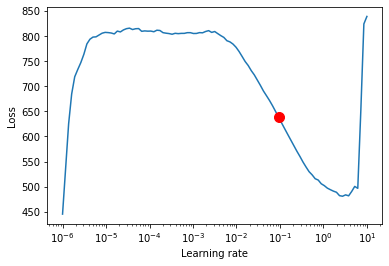

In [138]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [139]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 43.2k


In [140]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 352   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 13.7 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 13.7 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [141]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [142]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(71.2812)

In [143]:
test_list = glob('./aT_data/data/test/set_1/*.csv')
df_test = pd.read_csv(test_list[0])
# df_test['group_id'] = 0

df_test

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,주산지_2_최대온도(℃),주산지_2_최저온도(℃),주산지_2_평균온도(℃),주산지_2_강수량(ml),주산지_2_습도(%),일자구분_중순,일자구분_초순,일자구분_하순,월구분_2월,월구분_3월
0,20170226,2597.40,252.0,655655.0,4.0,250001.0,25000102.0,560.0,1999.077583,182741.0,...,15.3,-3.0,6.5,0.0,44.8,0,0,1,1,0
1,20170227,1541.54,70.0,107392.5,3.0,210001.0,21000102.0,621.0,1940.740624,198469.0,...,15.5,1.0,9.5,0.0,52.8,0,0,1,1,0
2,20170228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.3,-1.6,7.5,0.0,55.6,0,0,1,1,0
3,20170301,620.62,80.0,50050.0,1.0,230003.0,23000303.0,401.0,2054.058569,233421.0,...,7.7,1.0,5.4,40.2,90.7,0,1,0,0,1
4,20170302,1981.98,292.0,577577.0,4.0,230001.0,23000101.0,320.0,2073.866690,203541.0,...,7.2,-1.4,3.7,69.5,76.6,0,1,0,0,1
5,20170303,2382.38,40.0,95095.0,2.0,220001.0,22000106.0,719.0,1997.451460,219305.0,...,9.6,-3.3,2.9,0.0,71.7,0,1,0,0,1
6,20170304,2607.39,24.0,62637.3,1.0,310901.0,31090105.0,472.0,1968.545825,193849.0,...,12.7,1.0,7.7,0.0,73.0,0,1,0,0,1
7,20170305,1451.45,60.0,87087.0,1.0,210009.0,21000901.0,970.0,2181.100469,199588.0,...,16.3,1.0,10.2,0.0,73.6,0,1,0,0,1
8,20170306,1901.90,1368.0,2597799.6,7.0,110001.0,11000103.0,461.0,2987.253790,203557.0,...,11.4,2.5,6.4,0.0,72.0,0,1,0,0,1
9,20170307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.1,1.1,5.8,0.0,65.4,0,1,0,0,1


In [145]:
test_dataloader = df_test.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

AttributeError: 'DataFrame' object has no attribute 'to_dataloader'

In [144]:
best_tft.predict(df_test)

KeyError: 'group_id'

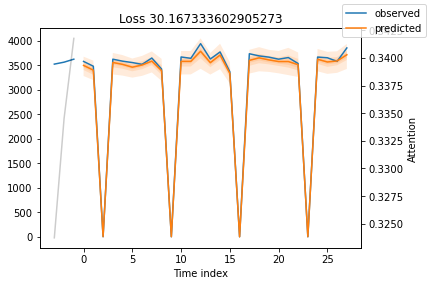

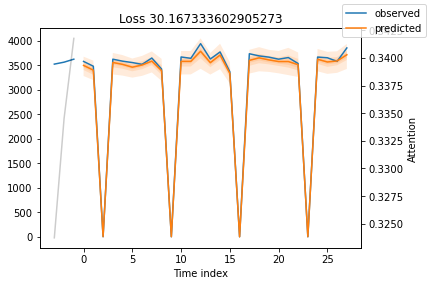

In [125]:
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)